In [26]:
# For gathering data from reddit
import praw # Python Reddit API Wrapper
from praw.models import MoreComments

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import FreqDist
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import re # Remove links
import en_core_web_sm
import spacy

import os
from dotenv import load_dotenv

# for visualization
import seaborn as sns
sns.set(style = 'whitegrid', palette = 'Dark2')
import matplotlib.pyplot as plt
from wordcloud import WordCloud, get_single_color_func
import plotly.express as px


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avanjavakam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
# loading development settings for Reddit API
%load_ext dotenv
%dotenv

# Create a reddit connection with reddit API details
reddit = praw.Reddit(client_id = os.getenv("CLIENT_ID"),
                     client_secret = os.getenv("CLIENT_SECRET"),
                     user_agent = os.getenv("USER_AGENT"))
reddit

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [28]:
subreddit = reddit.subreddit('all')
submissions_list = []
search_term = "regal unlimited subscription"
# search popular subreddits for reviews and get first 3 posts
for submission in subreddit.search(search_term,limit = 20,sort='top'):

    #print(submission.likes)
    #print(submission.num_comments)
    #print(submission.subreddit_subscribers)
    #print(submission.view_count)
    print(submission.upvote_ratio)
    print(submission.score)    
    print(submission.title)
       
    print('Submission ID = ', submission.id, '\n')
    submissions_list.append(submission.id)
submissions_list

0.77
13718
Hi, I’m Anthony Palma, founder of Jump, the “Netflix of Indie Games” service that launched on Tuesday. AMA!
Submission ID =  71iy3w 

0.95
13516
Regal Cinemas Unlimited Ticket Subscription Program Set To Launch This Month
Submission ID =  c80yte 

0.93
12384
If you use Alexa, make sure "she" didn't subscribe you to AmazonMusic Unlimited without your knowledge!
Submission ID =  c3bx74 

0.98
11880
YSK many Companies Are Offering Free Services And/Or Waiving Fees Due to the quarantine. Here’s a Full List
Submission ID =  fpdxob 

0.98
8653
[Home Crafting] When a company tried to make a bunch of stay at home moms pay rent to use a machine they already own during a global pandemic
Submission ID =  mmmcy7 

0.9
8088
I saved 88% on coffee insurance by switching to Panera (from Starbucks)
Submission ID =  ildmel 

0.99
8027
[Web Media] Critical Role and Orion Acaba: How to get kicked out of what is now Twitch's most successful channel so hard, people don't even know you were part o

['71iy3w',
 'c80yte',
 'c3bx74',
 'fpdxob',
 'mmmcy7',
 'ildmel',
 'q5c2xf',
 '4qzu9h',
 '12yeuzo',
 'sgf497',
 '1099h4y',
 'i7hx4t',
 'a01n6u',
 'xsccsy',
 'sm0vql',
 'p140g4',
 '10ckdts',
 'elryxp',
 'lzoci4',
 '5cjsva']

In [29]:

#top = subreddit.search(search_term,limit = 20,sort='top').top(params={'t': 'all'}, limit=25) # For a more potentially accurate set of top comments, increase the limit (but it'll take longer)
posts = dict()
all_comments = []
comments_body = []
top_comments_body = {}
    
# search all subreddits and get comments from top posts
for submission in subreddit.search(search_term, limit = 5, sort='relevance'):
    # sort comments by 'best' (which is default mode we see when using reddit)
    submission.comment_sort = 'best'

    # This line is required in case we need commentForest (includes replies tree)
    # or else there would be an error if we do not replace moreComments.
    submission.comments.replace_more(limit = None)

    # exlclude bot posts/advertised posts 
    if not submission.stickied:

        # add original post text to the posts dictionary
        posts[submission.selftext] = submission.score

        # for each post, get top level comments (no replies, no commentForest)
        #if top_level_comments_only:
        real_comments = [comment for comment in list(submission.comments)]
        # for comments and replies (includes commentForest)
        #else:                
            #real_comments = [comment for comment in submission.comments.list()]            
        all_comments += real_comments
# if the search term found any posts on reddit search
if posts:
    # sort all comments by no. of upvotes
    all_comments.sort(key=lambda comment: comment.score, reverse=True)

    # store top n comments with most no. of upvotes
    top_comments = all_comments[:5] #top 5 comments

    for comment in top_comments:
        top_comments_body[comment.body] = comment.score

    for comment in all_comments:
        comments_body.append(comment.body)

    for text, score in posts.items():    
        # add post texts to comments body
        comments_body.append(text)
else:
    print('No posts found! Please enter another search term')
        



In [30]:
# Pre-processing comments

# convert to a string object
# map to a list of strings
strings_all = [str(i) for i in comments_body]
# join all strings spearated by a commma
strings_uncleaned = ' , '.join(strings_all)
strings_uncleaned

# tokenizing and cleaning strings
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|http\S+')
tokenized_string = tokenizer.tokenize(strings_uncleaned)

# converting all tokens to lowercase
tokenized_string_lower = [word.lower() for word in tokenized_string]

# removing stop words
nlp = en_core_web_sm.load()
all_stopwords = nlp.Defaults.stop_words
tokens_without_stopwords = [word for word in tokenized_string_lower if not word in all_stopwords]

# stemming might return a root word that is not an actual word
# whereas, lemmatizing returns a root word that is an actual language word.
# let's normalize words via lemmatizing
lemmatizer = WordNetLemmatizer()

lemmatized_tokens = ([lemmatizer.lemmatize(w) for w in tokens_without_stopwords])
print(lemmatized_tokens)

print("number of words = ", len(lemmatized_tokens))


['automatically', 'go', 'month', 'month', 'end', '3', 'month', 'signup', 'fan', 'run', 'sub', 'don', 't', 'work', 'regal', '100', 'want', 'direct', 'complaint', 'cancellation', 'request', 'c', 'fastest', 'way', 'facebook', 'messenger', 'twitter', 'typically', '24', 'hour', 'cancelled', 'agree', 'suck', 'wish', 'cancel', 'button', 'don', 't', 'repeatedly', 'address', 'best', 'luck', 'd', 'appreciate', 'directing', 'legal', 'question', 'correct', 'sub', 'like', 'r', 'legaladvice', 'maybe', 'best', 'use', 'everyday', 'week', 'week', 'saw', 'blow', 'pipeline', 'suzume', 'renfield', 'john', 'wick', 'chapter', '4', 'beau', 'afraid', 'm', 'seeing', 'return', 'jedi', 'tomorrow', 'account', 'tied', 'single', 'device', 's', 'kind', 'hard', 'gift', 'surprise', 'd', 'steal', 'phone', 'steal', 'phone', 'set', 'wouldn', 't', 'need', 'id', 'picture', 'pick', 'photo', 'phone', 's', 'storage', 'best', 'way', 'gift', 'unlimited', 'gift', 'card', 'walk', 'setting', 'gift', 'card', 'payment', 'regular', '

In [31]:
# Applying a sentiment analyzer (VADER)
sia = SIA()
results = []

# get polarity score for words
for word in lemmatized_tokens:
    pol_score = sia.polarity_scores(word)
    pol_score['words'] = word
    results.append(pol_score)
results

pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df

,neg,neu,pos,compound,words
0,0.0,1.0,0.0,0.0000,automatically
1,0.0,1.0,0.0,0.0000,go
2,0.0,1.0,0.0,0.0000,month
3,0.0,1.0,0.0,0.0000,month
4,0.0,1.0,0.0,0.0000,end
...,...,...,...,...,...
452,0.0,1.0,0.0,0.0000,photo
453,0.0,1.0,0.0,0.0000,id
454,0.0,0.0,1.0,0.5267,kind
455,0.0,0.0,1.0,0.0772,want


In [32]:
# compound score as seen above is a normalized single unideimensional measure of sentiment for a given word.
# adding a label column
df['label'] = 0 # neutral
df.loc[df['compound'] > 0.10, 'label'] = 1 # positive
df.loc[df['compound'] < -0.10, 'label'] = -1 # negative
df.head()

,neg,neu,pos,compound,words,label
0,0.0,1.0,0.0,0.0,automatically,0
1,0.0,1.0,0.0,0.0,go,0
2,0.0,1.0,0.0,0.0,month,0
3,0.0,1.0,0.0,0.0,month,0
4,0.0,1.0,0.0,0.0,end,0


In [33]:
# how many words are neutral (0), positive (1) and negative (-1) in sentiment
df.label.value_counts()

 0    380
 1     52
-1     25
Name: label, dtype: int64

Most of them are neutral. Comments seem to be neutral - positive skewed.There are only 2 negative words.


In [34]:
# let's look at negative words
df[df['label']== -1]

,neg,neu,pos,compound,words,label
18,1.0,0.0,0.0,-0.2960,complaint,-1
30,1.0,0.0,0.0,-0.2500,cancelled,-1
32,1.0,0.0,0.0,-0.4404,suck,-1
34,1.0,0.0,0.0,-0.2500,cancel,-1
80,1.0,0.0,0.0,-0.1027,hard,-1
84,1.0,0.0,0.0,-0.4939,steal,-1
86,1.0,0.0,0.0,-0.4939,steal,-1
136,1.0,0.0,0.0,-0.1027,pay,-1
141,1.0,0.0,0.0,-0.1027,pay,-1
156,1.0,0.0,0.0,-0.1027,pay,-1


matplotlib.figure.Figure

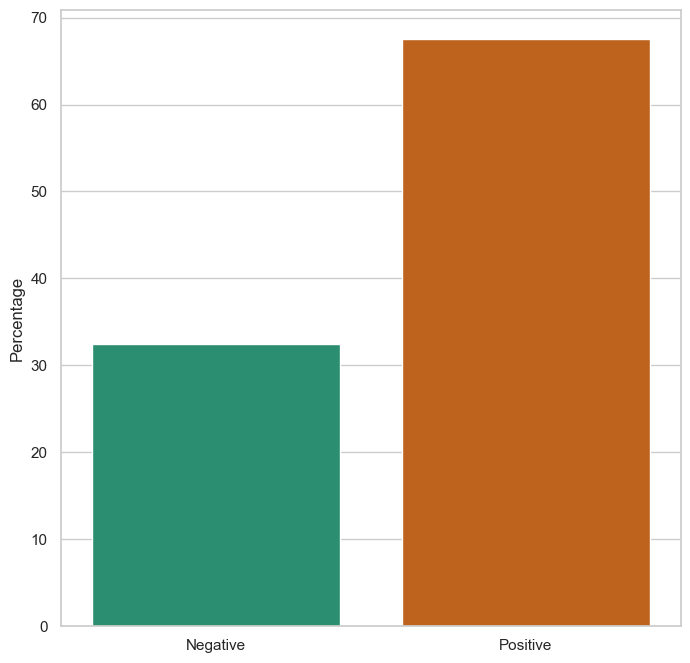

In [35]:
# let's look at how many positive and negative words are found

fig, ax = plt.subplots(figsize = (8,8))

counts = df.loc[df['label'] != 0]['label'].value_counts(normalize=True) * 100

sns.barplot(x = counts.index, y = counts, ax = ax)

ax.set_xticklabels(['Negative', 'Positive'])
ax.set_ylabel("Percentage")
type(fig)

In [36]:
# get percentage of postive and negative words in all the comments 
sentiment_perc_of_words = df.loc[df['label'] != 0]['label'].value_counts(normalize=True) * 100

print(sentiment_perc_of_words)
if sentiment_perc_of_words[1] == 100:
    sentiment_perc_of_words[-1] = 0
if sentiment_perc_of_words[-1] == 100:
    sentiment_perc_of_words[1] = 0

print(sentiment_perc_of_words)

#print(round(sentiment_perc_of_words[1],2))
#print(round(sentiment_perc_of_words[-1],2))


 1    67.532468
-1    32.467532
Name: label, dtype: float64
 1    67.532468
-1    32.467532
Name: label, dtype: float64


In [37]:
# Frequency distribution of the 20 most common positive words
frequent_pos_words = FreqDist(df.loc[df['label'] == 1].words)
frequent_pos_words


FreqDist({'gift': 11, 'like': 7, 'best': 3, 'great': 3, 'kind': 2, 'surprise': 2, 'nice': 2, 'sure': 2, 'good': 2, 'pretty': 2, ...})

In [38]:
sum(frequent_pos_words.values())

52

In [39]:
# Frequency distribution of the 20 most common negative words
frequent_neg_words = FreqDist(df.loc[df['label'] == -1].words)
frequent_neg_words.most_common(20)

[('cancel', 6),
 ('pay', 3),
 ('steal', 2),
 ('suspicious', 2),
 ('complaint', 1),
 ('cancelled', 1),
 ('suck', 1),
 ('hard', 1),
 ('ridiculous', 1),
 ('charged', 1),
 ('frustrating', 1),
 ('warn', 1),
 ('annoying', 1),
 ('offense', 1),
 ('difficult', 1),
 ('drop', 1)]

In [40]:
color_words_dict = {
    'green': list(df.loc[df['label'] == 1].words),
    'red': list(df.loc[df['label'] == -1].words)
}

# neutral words are grey
default_color = 'grey'
color_words_dict

{'green': ['fan',
  'agree',
  'wish',
  'best',
  'luck',
  'appreciate',
  'legal',
  'like',
  'best',
  'kind',
  'gift',
  'surprise',
  'best',
  'gift',
  'gift',
  'gift',
  'gift',
  'gift',
  'gift',
  'gift',
  'free',
  'credit',
  'gift',
  'gift',
  'nice',
  'gift',
  'credited',
  'yes',
  'sure',
  'great',
  'better',
  'nice',
  'like',
  'awesome',
  'worth',
  'like',
  'certain',
  'great',
  'good',
  'good',
  'like',
  'great',
  'like',
  'like',
  'commitment',
  'pretty',
  'sure',
  'actively',
  'pretty',
  'like',
  'kind',
  'surprise'],
 'red': ['complaint',
  'cancelled',
  'suck',
  'cancel',
  'hard',
  'steal',
  'steal',
  'pay',
  'pay',
  'pay',
  'ridiculous',
  'charged',
  'frustrating',
  'warn',
  'cancel',
  'cancel',
  'annoying',
  'offense',
  'difficult',
  'cancel',
  'cancel',
  'suspicious',
  'cancel',
  'drop',
  'suspicious']}

In [41]:
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

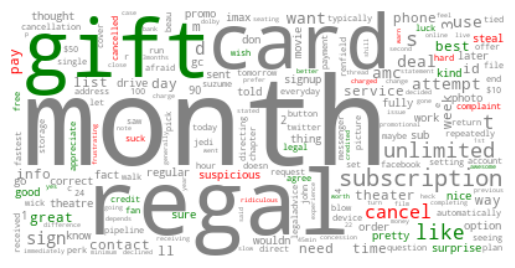

In [42]:
wc = WordCloud(collocations=False, background_color='white').generate_from_frequencies(frequencies=FreqDist(df.words))

grouped_color_func = SimpleGroupedColorFunc(color_words_dict, default_color)
wc.recolor(color_func=grouped_color_func)
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [43]:
# how many common words to display
no_of_words = 20

# Most common positive words
pos_freq_df = pd.DataFrame(frequent_pos_words.most_common(no_of_words))
pos_freq_df = pos_freq_df.rename(columns = {0: "Bar Graph of Frequent Positive Words", 1: "Count"}, inplace=False)

fig = px.bar(pos_freq_df, x = "Bar Graph of Frequent Positive Words", y = "Count", title = "Commonly Used Positive Words Count")

fig.show()

In [45]:
# Most common negative words

neg_freq_df = pd.DataFrame(frequent_neg_words.most_common(no_of_words))
neg_freq_df = neg_freq_df.rename(columns = {0: "Bar Graph of Frequent Negative Words", 1: "Count"}, inplace=False)

fig = px.bar(neg_freq_df, x = "Bar Graph of Frequent Negative Words", y = "Count", title = "Commonly Used Negative Words Count")

fig.show()

Ideas for improvement:

Try sentiment for sentences instead of words. There may be some sentences such as "They try to take away my uncertainity and nervousness" which is obviously positive but the individual words "uncertainity" and "nervousness" contribute more to negative score.

References:
- https://www.learndatasci.com/tutorials/predicting-reddit-news-sentiment-naive-bayes-text-classifiers/
- https://www.nltk.org/
- https://praw.readthedocs.io/en/latest/tutorials/comments.html#extracting-comments-with-praw
- https://stackoverflow.com/questions/61919884/mapping-wordcloud-color-to-a-value-for-sentiment-analysis
- https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
- https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
- https://docs.streamlit.io/

